In [1]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.filterwarnings("ignore", message="the matrix subclass is")
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [2]:
import math
import numpy as np
np.set_printoptions(precision=3)
from scipy.spatial.distance import pdist, squareform
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

import os
import sys
sys.path.append("../../")

from distance_matching import DistanceMatching
import time
import functions
from utils import *
import matplotlib.pyplot as plt

In [3]:
import warnings
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
warnings.filterwarnings("ignore", message="the matrix subclass is")
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

import pandas as pd
df = pd.read_csv("~/Desktop/OnlineNews/OnlineNewsPopularity/OnlineNewsPopularity.csv", header=0, sep=',')
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,shares
0,http://mashable.com/2013/01/07/amazon-instant-...,731.0,12.0,219.0,0.663594,1.0,0.815385,4.0,2.0,1.0,...,0.100000,0.7,-0.350000,-0.600,-0.200000,0.500000,-0.187500,0.000000,0.187500,593
1,http://mashable.com/2013/01/07/ap-samsung-spon...,731.0,9.0,255.0,0.604743,1.0,0.791946,3.0,1.0,1.0,...,0.033333,0.7,-0.118750,-0.125,-0.100000,0.000000,0.000000,0.500000,0.000000,711
2,http://mashable.com/2013/01/07/apple-40-billio...,731.0,9.0,211.0,0.575130,1.0,0.663866,3.0,1.0,1.0,...,0.100000,1.0,-0.466667,-0.800,-0.133333,0.000000,0.000000,0.500000,0.000000,1500
3,http://mashable.com/2013/01/07/astronaut-notre...,731.0,9.0,531.0,0.503788,1.0,0.665635,9.0,0.0,1.0,...,0.136364,0.8,-0.369697,-0.600,-0.166667,0.000000,0.000000,0.500000,0.000000,1200
4,http://mashable.com/2013/01/07/att-u-verse-apps/,731.0,13.0,1072.0,0.415646,1.0,0.540890,19.0,19.0,20.0,...,0.033333,1.0,-0.220192,-0.500,-0.050000,0.454545,0.136364,0.045455,0.136364,505


In [4]:
# I’m using the log of the number of shares as the single target Y,
Y = np.log(df[[' shares']].values)
# LDA features as U,
U_names = [' LDA_00', ' LDA_01', ' LDA_02', ' LDA_03', ' LDA_04']
U = df[U_names].values
# and all other features except for ‘url’ and ‘timedelta’ as X.
X_cols = set(df.columns) - set(U_names) - set([' shares']) - set(['url', 'timedelta'])
X = df[X_cols]
print(Y.shape, U.shape, X.shape)

(39644, 1) (39644, 5) (39644, 54)


In [5]:
X_train, X_test, Y_train, Y_test, U_train, U_test = train_test_split(X.values, Y, U, test_size=0.9)

In [6]:
X_means = np.mean(X_train, axis=0)
X_stds  = np.std(X_train, axis=0)

X_train = (X_train - X_means) / X_stds
X_test  = (X_test  - X_means) / X_stds

In [7]:
Y_mean = np.mean(Y_train)
Y_std  = np.std(Y_train)
Y_train = (Y_train - Y_mean) / Y_std
Y_test  = (Y_test  - Y_mean) / Y_std

In [8]:
from sklearn.linear_model import ElasticNet
lr = ElasticNet(fit_intercept=False, alpha=0.1)
lr.fit(X_train, Y_train)
lr_beta = np.array([lr.coef_ for _ in range(X_train.shape[0])])

from sklearn.metrics import mean_squared_error as mse
print(mse(Y_test, lr.predict(X_test)))

0.9342754494470813


In [10]:
# Define regularization functions.
f       = functions.linear_loss
f_prime = functions.linear_loss_prime

(N_train, P) = X_train.shape
K = U_train.shape[1]

# Personalization Hyper-parameters.
n_neighbors = 5
gamma = 1e3   # Pairwise Regularization Strength
upsilon = 1e-3 # Phi_U Regularization Strength

lam = 1e-1
# Lasso regularization on beta
beta_target = np.zeros((P))
rho_beta       = lambda beta, i: lam*functions.lasso_penalty(beta, beta_target)
rho_beta_prime = lambda beta, i: lam*functions.lasso_derivative(beta, beta_target)

# Regularization on phi_u
init_phi_u      = soft_normalize(np.ones((K)))
# Lasso penalty for sparisty in personalization.
psi_u = lambda phi_u: upsilon*np.linalg.norm(phi_u - np.zeros((K)), ord=1)
psi_u_prime = lambda phi_u: upsilon*np.sign(phi_u - np.zeros((K)))

dml = DistanceMatching(lr_beta+np.random.uniform(-1e-4, 1e-4, size=lr_beta.shape),#vc_beta,
    f, f_prime,
    gamma, latent_dim=2,
    n_neighbors=n_neighbors, update_ztree_every=10,
    calc_dist_errors_every=1,
    calc_closest_every=10,
    rho_beta=rho_beta, rho_beta_prime=rho_beta_prime,
    init_phi_u=init_phi_u, psi_u=psi_u, psi_u_prime=psi_u_prime,
    intercept=False, log_dir='./', n_threads=1)

In [11]:
### Distance Matching
print("======Fitting Least Squares with Learned Metrics======")

dU = [lambda x,y: np.abs(x-y) for _ in range(K)]
delta_U_fname="simple_delta_U"
delta_U = create_delta_U(dml, U_train, dU, K, N_train, delta_U_fname, normalize=False)

======Fitting Least Squares with Learned Metrics======
Calculating Pairwise Co-Variate Distances...
Making Co-Variate Distance Matrix of Size 3964x3964x5
Finished making unnormalized version.
Finished normalizing.
Took 289.000 seconds.
Finished. Took 289.000 seconds.
Saving Pairwise Co-Variate Distances to simple_delta_U


Fitting Least Squares with Learned Metrics
Restart 1 of 1
(54,)
[[-7.9973e-05 -2.2460e-05 -9.1049e-05 ...  1.8214e-05  4.8929e-05
  -5.7761e-05]
 [ 3.3080e-05 -2.2057e-05 -3.2180e-05 ... -4.7978e-05 -8.1976e-05
   5.2297e-05]
 [-3.3528e-05 -2.4284e-05  3.1577e-05 ... -1.1641e-05 -6.9878e-05
   4.1335e-05]
 ...
 [-9.7184e-05 -9.2501e-05  4.1833e-05 ... -2.0073e-05 -1.5670e-05
  -2.4768e-05]
 [-1.3842e-05  3.1057e-05 -9.0627e-05 ... -7.1547e-05 -7.5294e-05
  -5.8975e-05]
 [ 1.8652e-05 -4.7322e-05 -7.9073e-05 ... -9.4747e-05  2.7393e-05
  -8.4835e-05]]
[[ 1.9333e-05  1.7071e-05 -4.7101e-06 ...  4.2654e-06  3.1194e-05
   2.6880e-06]
 [ 6.4549e-06  5.4114e-06 -2.3782e-06 ... -2.0632e-06  6.9211e-06
   1.3398e-05]
 [-4.3151e-07 -5.0048e-07 -2.2852e-07 ... -1.5396e-06 -2.1435e-06
   5.1176e-06]
 ...
 [-9.7275e-06 -8.3235e-06  3.1134e-06 ...  1.0721e-06 -1.2471e-05
  -1.2889e-05]
 [-6.6050e-06 -5.7551e-06  1.8250e-06 ... -5.2290e-07 -9.7213e-06
  -4.2677e-06]
 [-1.5116e-05 -1.3026e-05  4.5823e

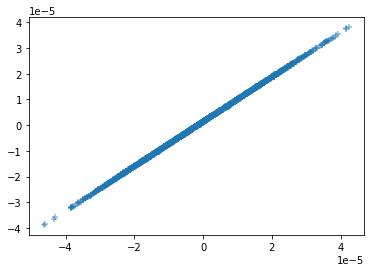

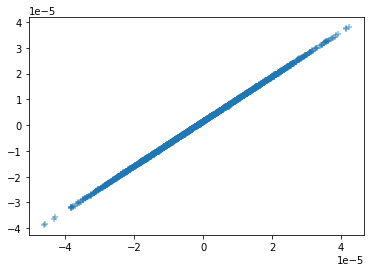

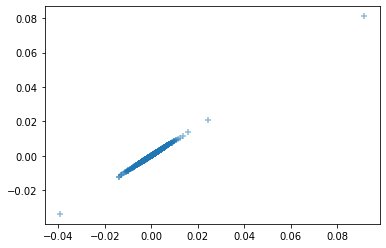

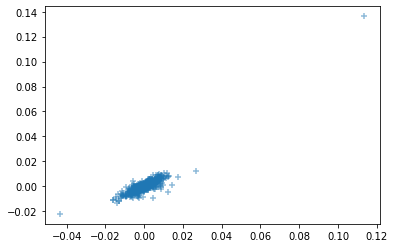

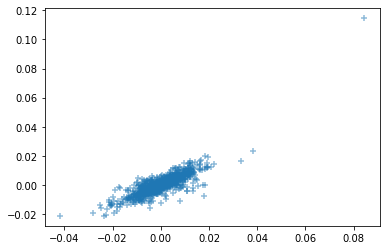

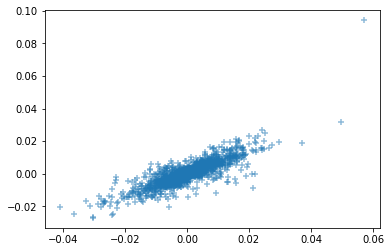

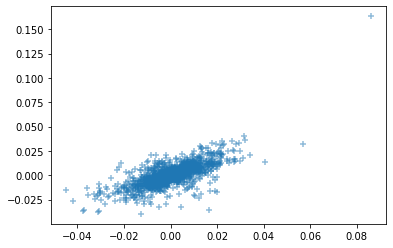

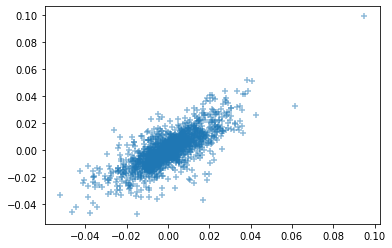

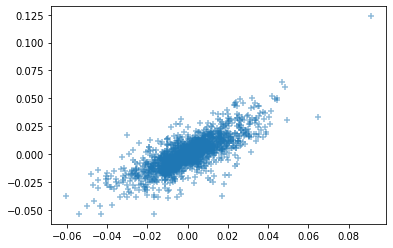

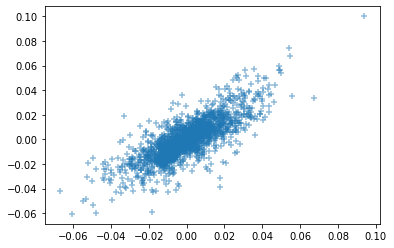

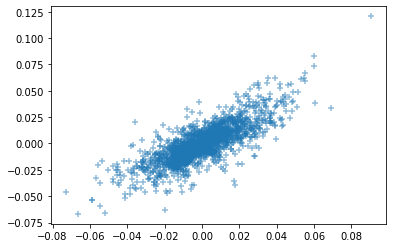

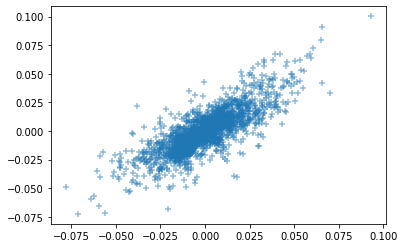

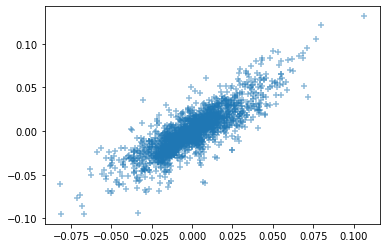

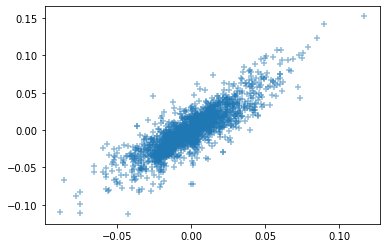

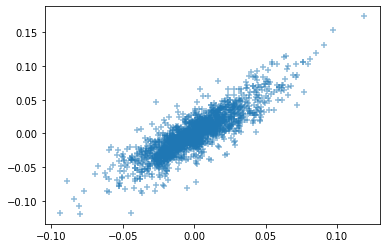

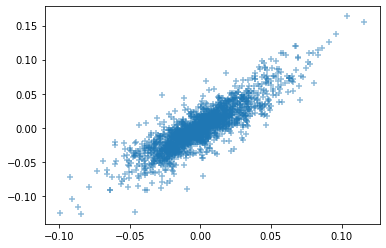

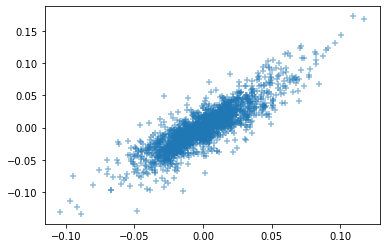

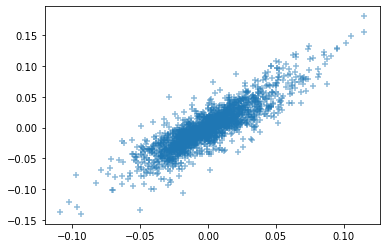

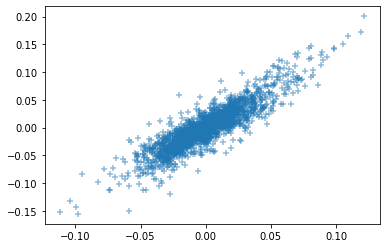

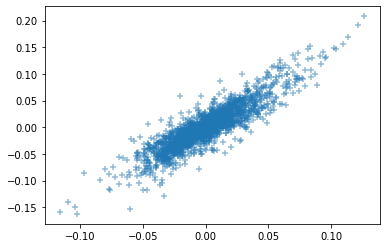

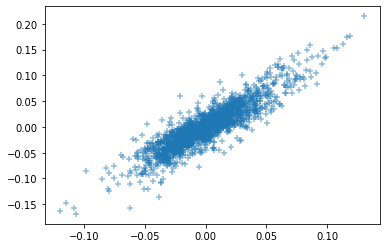

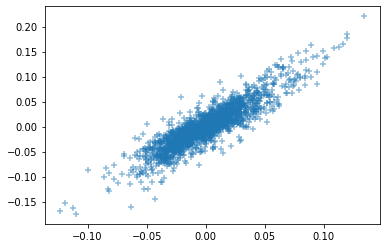

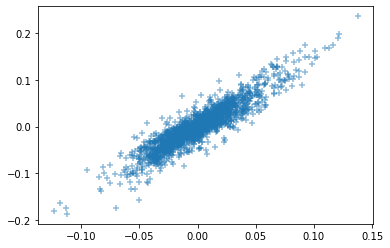

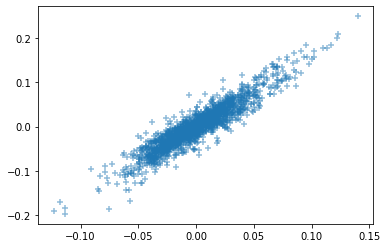

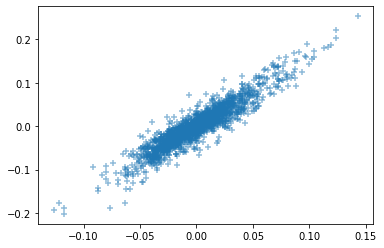

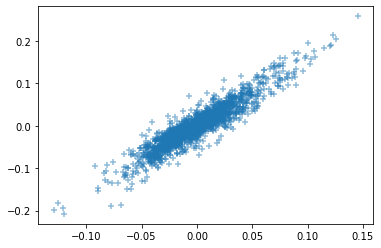

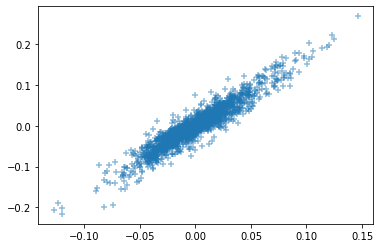

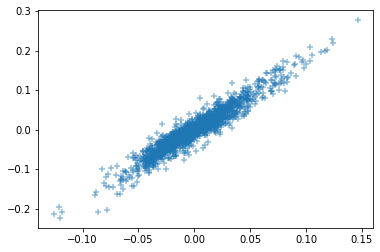

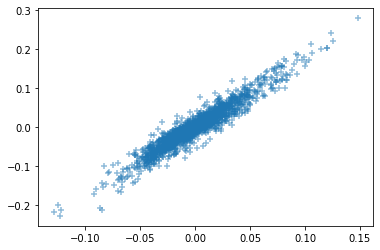

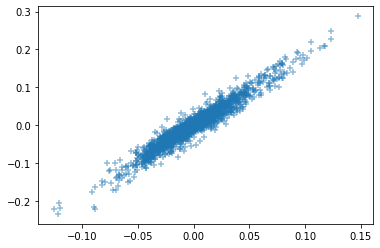

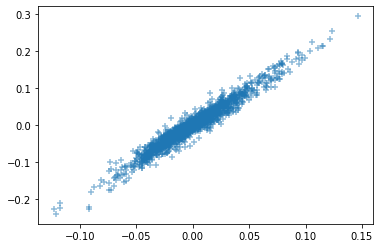

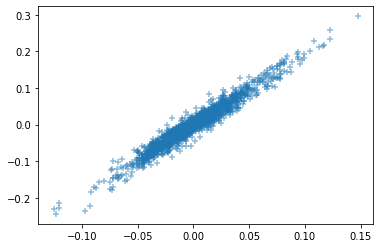

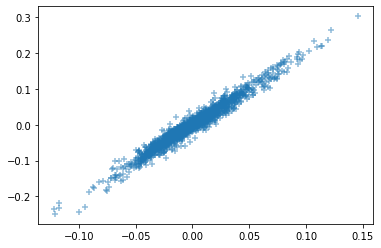

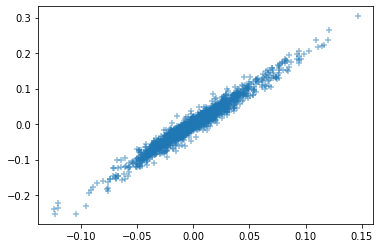

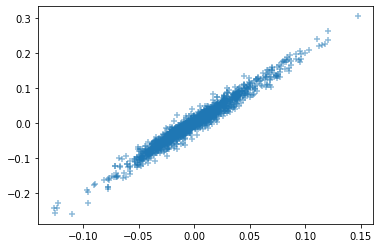

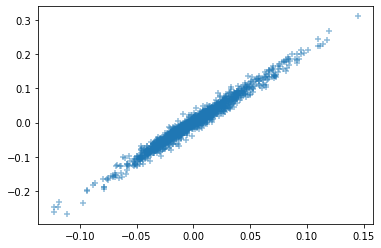

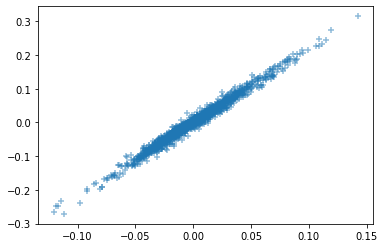

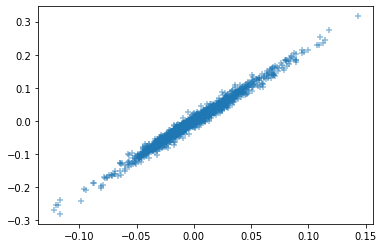

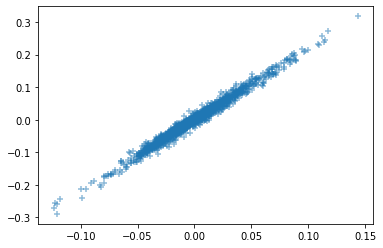

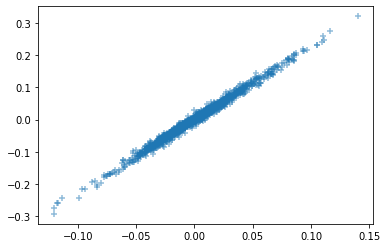

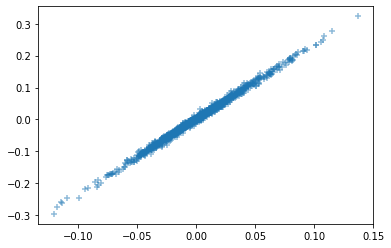

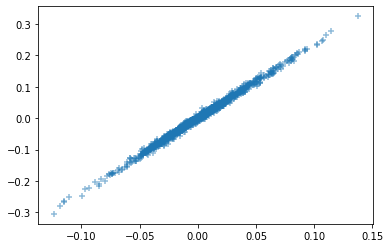

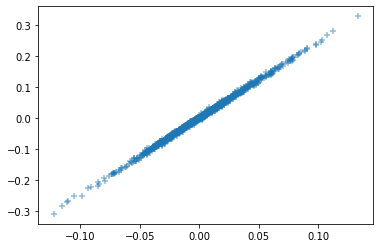

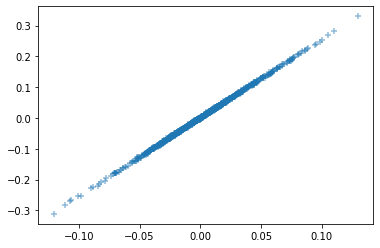

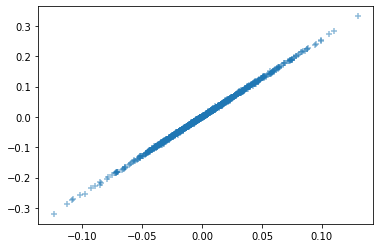

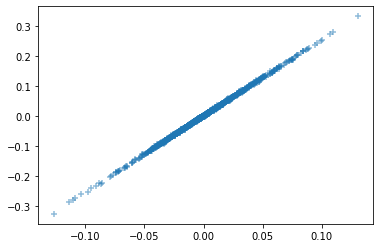

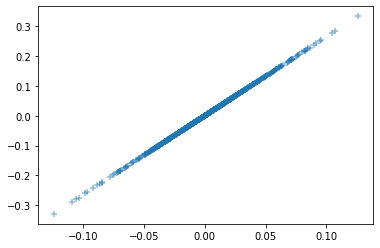

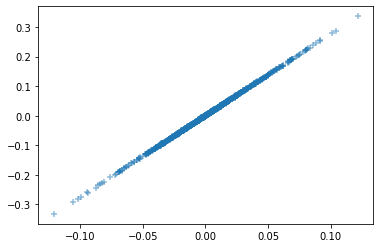

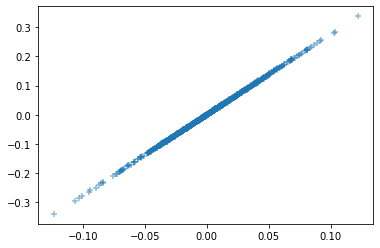

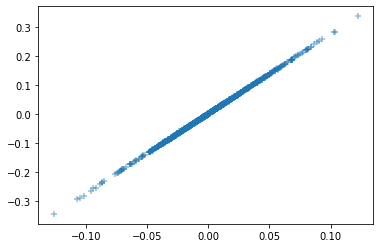

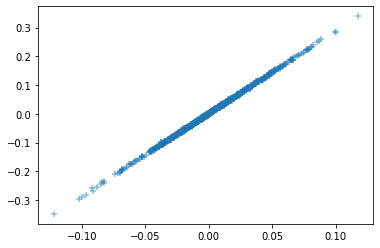

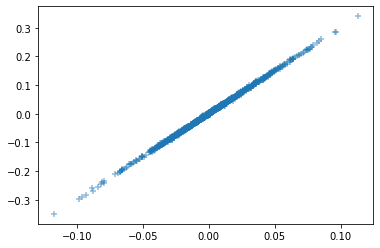

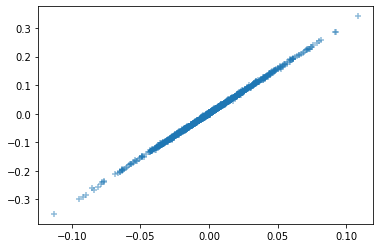

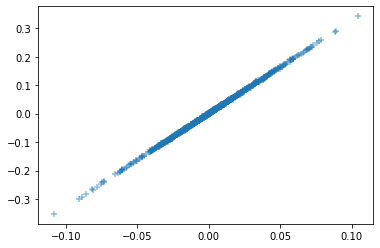

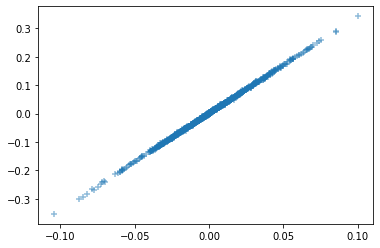

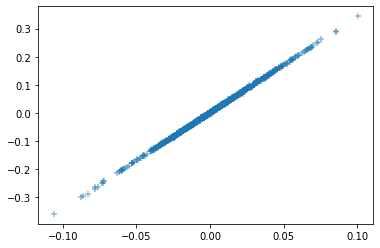

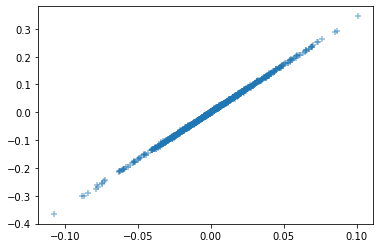

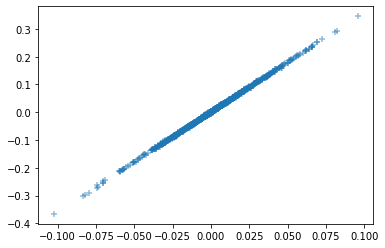

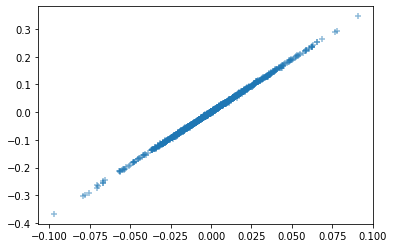

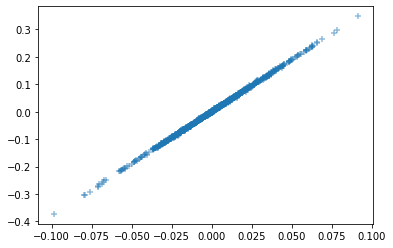

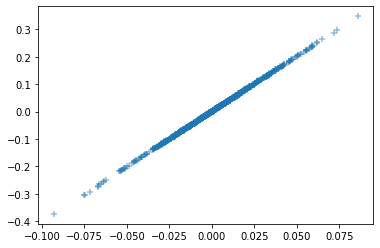

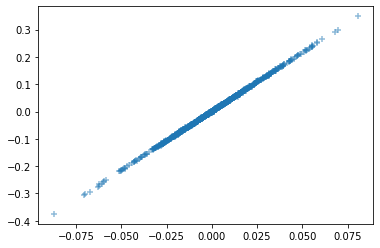

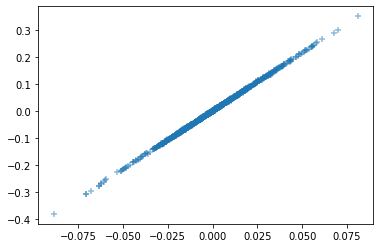

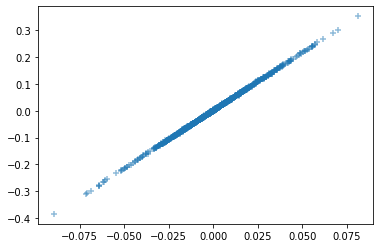

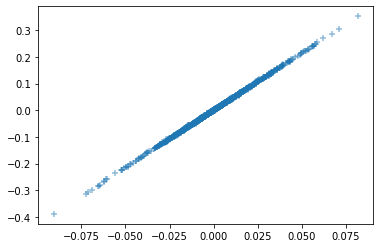

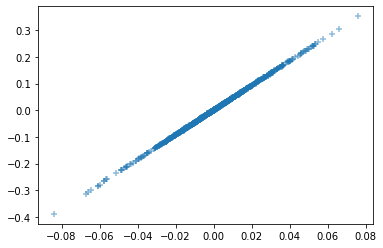

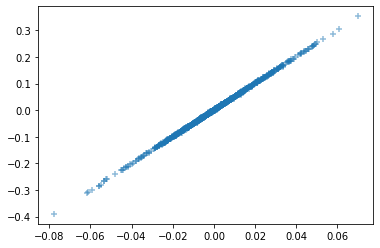

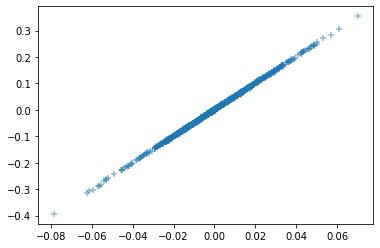

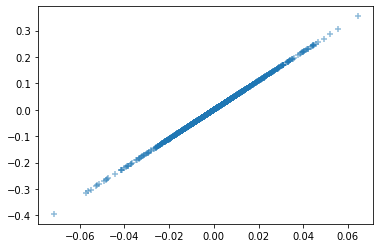

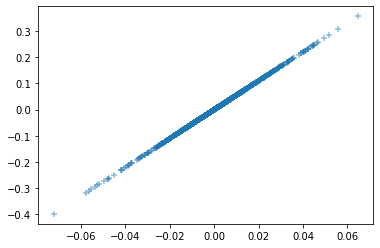

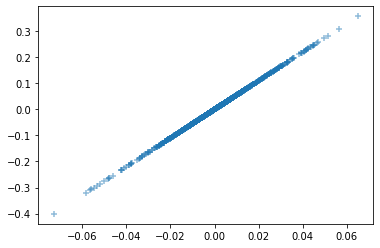

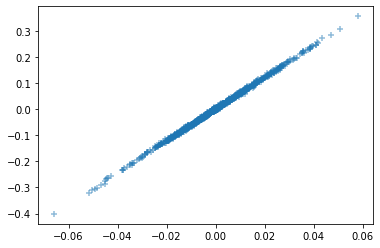

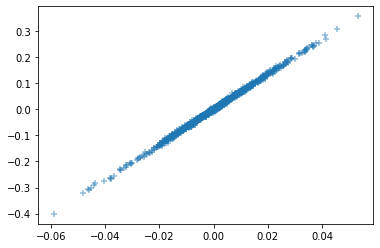

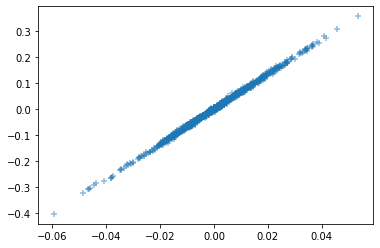

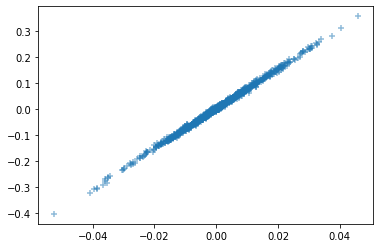

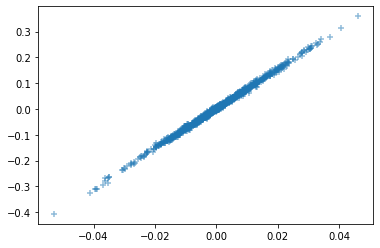

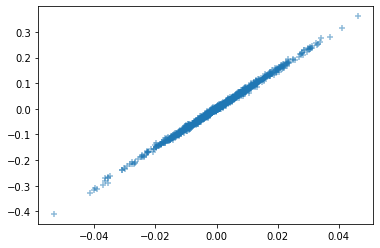

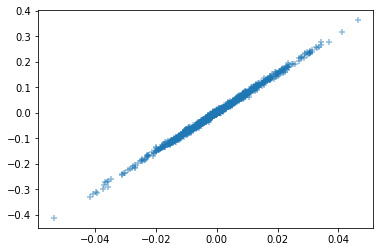

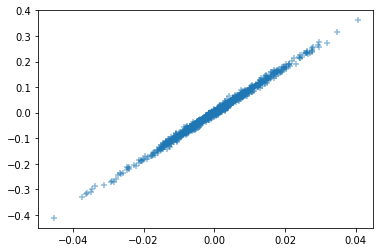

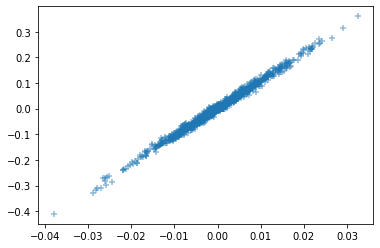

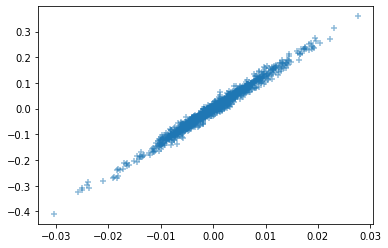

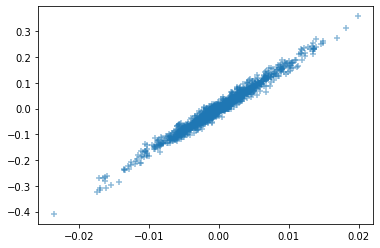

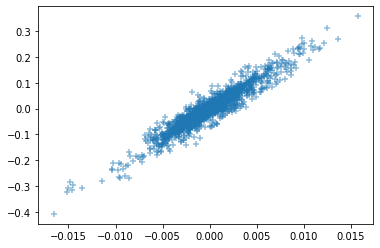

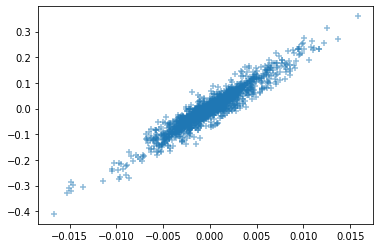

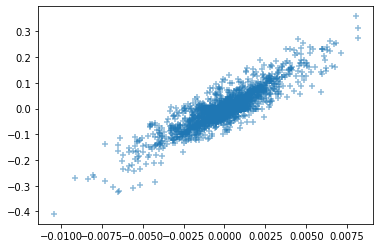

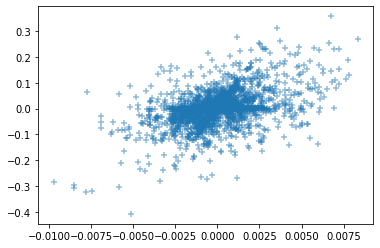

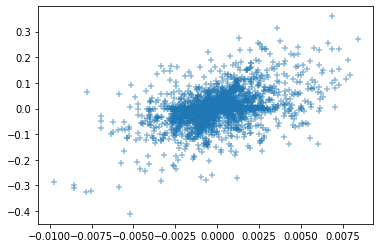

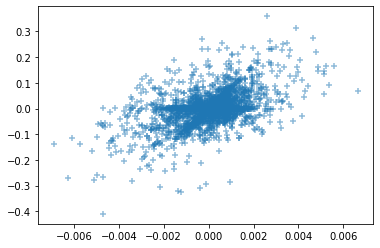

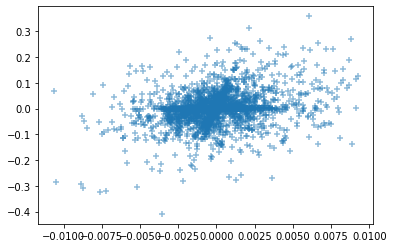

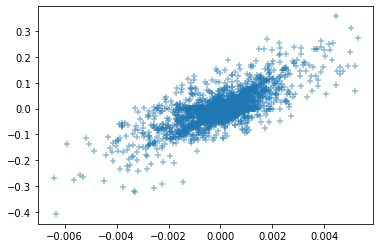

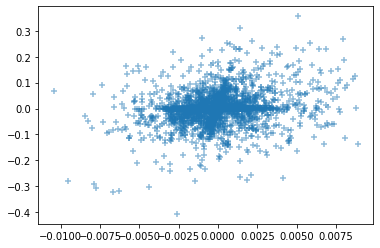

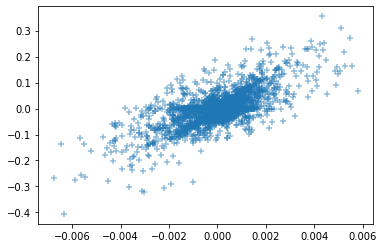

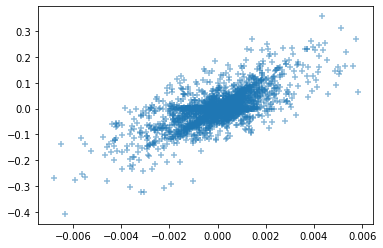

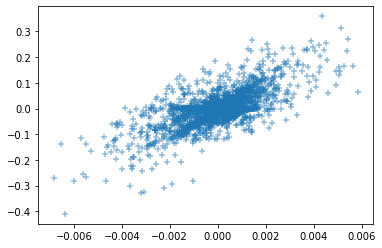

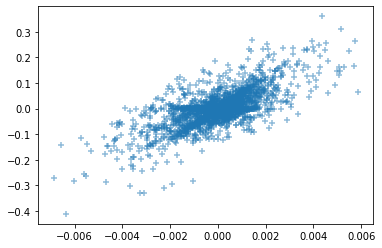

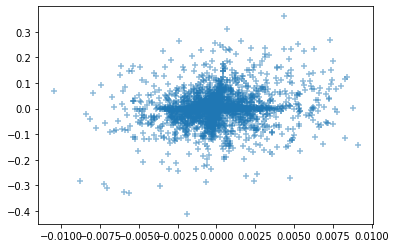

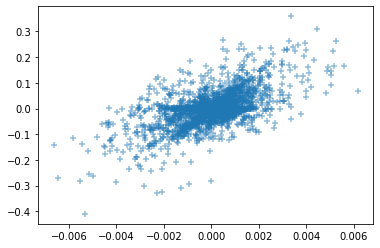

Reached local minimum at iteration 97.
Took 144.211 seconds.
** New best solution **


In [12]:
print("Fitting Least Squares with Learned Metrics")
z_dmr, q_dmr = dml.fit(
    X_train, Y_train, U_train, dU, delta_U=delta_U,
    init_lr=1e-3, lr_decay=1-1e-4, n_restarts=1,
    calc_neighbors=True,
    init_patience=20, max_iters=2000, tol=1e-8,
    verbosity=1, log_file=None)

beta_hat_learned = dml.beta_hat

In [13]:
def make_preds(X_test, U_test, beta_hat, n_neighbors=3):
    N_test = X_test.shape[0]
    test_beta_idx = [np.argsort(np.squeeze(np.abs(U_train - U_test[i]).dot(dml.phi_u)))[:n_neighbors] for i in range(N_test)]
    test_preds = np.array([X_test[i].dot(np.mean(beta_hat[test_beta_idx[i]], axis=0)) for i in range(N_test)])
    return test_preds

In [14]:
print(mse(Y_train, lr.predict(X_train)))
print(mse(Y_test, lr.predict(X_test)))
print(mse(Y_train, make_preds(X_train, U_train, beta_hat_learned)))
print(mse(Y_test, make_preds(X_test, U_test, beta_hat_learned)))

0.9107407255730121
0.9342754494470813
0.606558392960178
1.0448373159792708
